In [3]:
import salem

In [139]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import folium
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, Polygon
import warnings
warnings.filterwarnings("ignore") # At your own risk!
import seaborn as sns
import cmocean as cm
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates
sns.set(style="darkgrid")
sns.set_style("ticks")



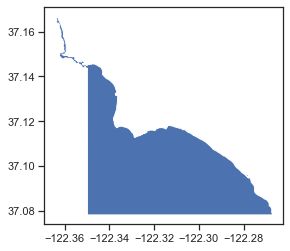

In [5]:
file = "../Data/MPA Shapefiles/mpa_ca/mpa_caPolygon.shp"
mpa_shapes_epsg = gpd.GeoDataFrame.from_file(file)
mpa_shapes_WGS84 = mpa_shapes_epsg.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})
ano_nuevo_shape = mpa_shapes_WGS84[mpa_shapes_WGS84['name']=="Año Nuevo SMCA"]
ano_nuevo_shape.plot()

__Find all MOPS locations that fall within the boundaries of the Ano Nuevo MPA__

From MOPS location information page

Column 1: Sequence number, transects are numbered from south to north

Column 2: Label, composed of a 1 or 2 character county label plus the transect
  number within that county. E.g. OC478 is the 478th transect in Orange County.

Column 3: Backbeach longitude, in decimal degrees. (Used by the model for
  calculating the shore normal and related parameters.)

Column 4: Backbeach latitude, in decimal degrees. (Used by the model for
  calculating the shore normal and related parameters.)

Column 5: Prediction site longitude, in decimal degrees.

Column 6: Prediction site latitude, in decimal degrees.

Column 7: Prediction site depth, in meters.

Column 8: Shore normal, in degrees true.

Column 9: Shore type flag. Sites with a value of 1 - indicating a natural
  coastline with planar bathymetry - will have extended nearshore parameters
  (Sxy, Sxx, Dm) included in the predictions. Other flag values are
  0 - coastal structures; 2 - complex bathymetry; 3 - offshore or unspecified.
 

In [6]:
fname = "MOPS_LOCATIONS.txt"
header = ['seq_num', 'label','back_lon', 'back_lat', 'lon', 'lat', 'depth', 'shore_normal', 'shore_type']

df = pd.read_csv(fname, delimiter="\t", skiprows=30, names=header)
df = df[(df['lat'] > 36) & (df['lat'] < 37.2)]

In [7]:
ano_nuevo_shape
df['coord_points'] = [Point(lon, lat) for lat, lon in zip(df['lat'].values, df['lon'].values)]
df['within_mpa'] = [p.within(ano_nuevo_shape['geometry'].values[0]) for p in df['coord_points'].values]

In [9]:
m = folium.Map([36.95, -121.9], zoom_start=9, control_scale=True)
within_mpa = df[df['within_mpa'] == True]
    
for lon,lat,label in within_mpa[['lon','lat','label']].values:
    folium.Marker(location=[lat,lon],popup = label, 
                      icon_color='red').add_to(m)
    
#     message = HTML()
#     message.value = label
#     marker.popup = message
#     m.add_layer(marker)

# m.save('m_bay_MOPS_site.html')


In [100]:
wave_variables = ['waveTp','waveDp','waveSxy','waveSxx','waveDm']

def grab_MOPS_Hs(site, param='waveHs'):
    '''Get MOPS data based on the site name, return pandas dataframe of Hs for timeseries'''
    url_hind = "https://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/model/MOP_alongshore/"+site+"_hindcast.nc"
    url_now = "https://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/model/MOP_alongshore/"+site+"_nowcast.nc"
    ds = xr.open_mfdataset([url_hind,url_now], decode_cf=True, parallel=True)
    return ds[param].to_pandas()


In [12]:
site = within_mpa['label'].values[0]
url_now = "https://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/model/MOP_alongshore/"+site+"_nowcast.nc"
url_hind = "https://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/model/MOP_alongshore/"+site+"_hindcast.nc"

ds = xr.open_mfdataset([url_now], decode_cf=True, parallel=True)

In [32]:
df_wed = ds['waveEnergyDensity'].to_pandas()
recent_wed = df_wed[df_wed.index > "20191215"]
cols = recent_wed.columns
recent_wed.columns = recent_wed.columns.map(lambda x : round(x,4))

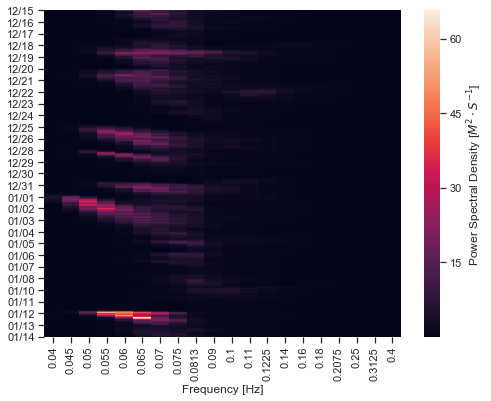

In [99]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
sns.heatmap(recent_wed, ax=ax, cbar_kws={'label': 'Power Spectral Density [$M^2 \cdot S^{-1}$]'})
dates = [pd.to_datetime(ylabel.get_text()).strftime('%m/%d') for ylabel in ax.get_yticklabels()[:]]
ax.set_yticklabels(dates);
ax.set_ylabel("")
ax.set_xlabel("Frequency [Hz]")
# plt.savefig('../Figures/MOPS_PSD_recent.png', dpi=300,bbox_inches='tight',pad_inches=.25)

In [102]:
df_stress = pd.DataFrame()
for site in within_mpa['label'].values[:]:
    df_stress[site] = grab_MOPS_Hs(site,param='waveSxy')
    
# df.save_csv('../Data/ano_nuevo_MOPS_sites.csv')

In [105]:
df_stress.index = pd.to_datetime(df_stress.index)

# df_mean['wvht']
df_stress = pd.DataFrame(df_stress.mean(axis=1))
df_stress = df_stress.rename(columns={0:'waveSxy'})
df_stress['month'] = df_stress.index.month
df_stress['season'] = "empty"


months = df_stress['month'].values
seasons = df_stress['season'].values
ix = np.where(((months>=3)&(months<=6)))
seasons[ix] = 'upwelling'
ix = np.where(((months>=7)&(months<=10)))
seasons[ix] = 'relaxation'
ix = np.where(((months>=11)|(months<=2)))
seasons[ix] = 'storm'
df_stress['season'] = seasons

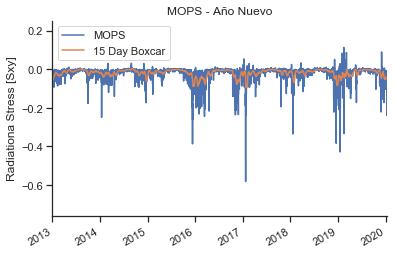

In [112]:
fig, (ax1) = plt.subplots(1)
df_stress['waveSxy'].plot(ax=ax1, label='MOPS')
df_stress['waveSxy'].rolling('15D').mean().plot(ax=ax1, label='15 Day Boxcar')
ax1.legend()
# ax1.set_ylim(0,3.25)
ax1.set_ylabel("Radiationa Stress [Sxy]")
ax1.set_xlabel("")
ax1.set_title('MOPS - Año Nuevo')
ax1.set_xlim('20130101','20200114')
plt.savefig('../Figures/MOPS_Sxy_2013Present.png', dpi=300,bbox_inches='tight',pad_inches=.25)

In [114]:
df = pd.DataFrame()
for site in within_mpa['label'].values[:]:
    df[site] = grab_MOPS_Hs(site)
    
# df.save_csv('../Data/ano_nuevo_MOPS_sites.csv')

In [115]:
recent_df = df[df.index > "20191215"]

In [118]:
from matplotlib.colors import Normalize, LogNorm
import matplotlib
import scipy.ndimage as ndimage

In [124]:
bathy = xr.open_dataset('../Data/MPA Bathy Subsets/ano_nuevo_SMR_bathy.nc')
y = bathy['lat'].values
x = bathy['lon'].values
xx,yy = np.meshgrid(x, y)
elv = bathy['Band1'].values
elv_smooth = ndimage.gaussian_filter(elv, sigma=2, order=0)
elv[elv>.5] = np.nan
# Use custom colormap function from Earle
def custom_div_cmap(numcolors=11, name='custom_div_cmap',
                    mincol='blue', midcol='white', maxcol='red'):
    """ Create a custom diverging colormap with three colors
    
    Default is blue to white to red with 11 colors.  Colors can be specified
    in any way understandable by matplotlib.colors.ColorConverter.to_rgb()
    """

    from matplotlib.colors import LinearSegmentedColormap 
    
    cmap = LinearSegmentedColormap.from_list(name=name, 
                                             colors =[mincol, midcol, maxcol],
                                             N=numcolors)
    return cmap

# make negative contours, normally dashed by default, be solid
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
blevels = np.concatenate((np.arange(-150,-40,20),np.arange(-40,1,5)))
N = len(blevels)-1
bnorm = matplotlib.colors.BoundaryNorm(blevels, ncolors=N, clip=False)
cmap2 = custom_div_cmap(N, mincol='DarkBlue', midcol='CornflowerBlue' ,maxcol='w')
cmap2.set_over('0.7') # light gray



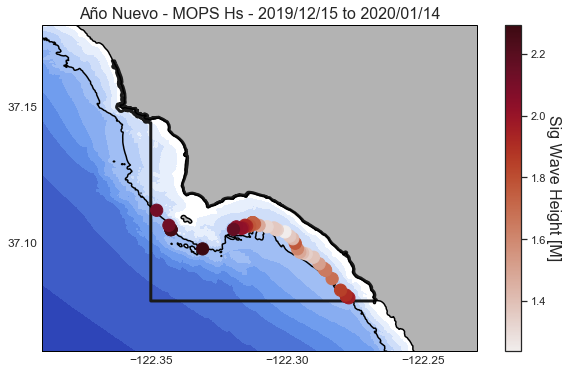

In [151]:
fig = plt.figure()
fig.set_size_inches(10,6)
ax = plt.axes(projection=ccrs.PlateCarree())
pc = ax.contourf(xx,yy,elv_smooth, norm=bnorm, vmin=blevels.min(), vmax=blevels.max(), levels=blevels, cmap=cmap2, extend='both')
ano_nuevo_shape.plot(ax=ax,edgecolor='k',facecolor='None', linewidth=3)

# plt.colorbar(pc, ticks=blevels, spacing='uniform') 
# plt.colorbar(pc, ticks=blevels)

cl = ax.contour(xx,yy,elv_smooth,levels=[-20], colors='black',zorder=20)
# ax.coastlines(resolution='10m')
cl = ax.contour(xx,yy,elv_smooth,levels=[-1.], colors='black',zorder=20)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlines = False
gl.ylines = False

gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = matplotlib.ticker.FixedLocator([-122.35,-122.3,-122.25])
gl.ylocator = matplotlib.ticker.FixedLocator([37.05,37.1,37.15])

ax.set_ylim(37.06, 37.18)
ax.set_xlim(-122.39,-122.23)

within_mpa['mean_hs'] = within_mpa["label"].map(recent_df.mean(axis=0))
cax = ax.scatter(within_mpa['lon'], within_mpa['lat'],c=within_mpa['mean_hs'],zorder=30,s=150,cmap=cm.cm.amp)
cbar = plt.colorbar(cax,)
cbar.ax.get_yaxis().labelpad = 15


cbar.ax.set_ylabel('Sig Wave Height [M]', rotation=270,size=16)
ax.set_title("Año Nuevo - MOPS Hs - 2019/12/15 to 2020/01/14",size=16)

# plt.savefig('../Figures/ano_nuevo_smr_MOPS_sites_map.png', dpi=300,bbox_inches='tight',pad_inches=.25)

In [132]:
within_mpa.head()

,seq_num,label,back_lon,back_lat,lon,lat,depth,shore_normal,shore_type,coord_points,within_mpa,mean_hs
7511,7512,SC310,-122.2684,37.0821,-122.27713,37.07950,-15.00,249.53,2,POINT (-122.27713 37.0795),True,1.956992
7512,7513,SC311,-122.2691,37.0838,-122.27793,37.07992,-15.00,241.15,2,POINT (-122.27793 37.07992),True,1.970125
7513,7514,SC312,-122.2704,37.0852,-122.27793,37.07992,-15.00,228.69,1,POINT (-122.27793 37.07992),True,1.970125
7514,7515,SC313,-122.2722,37.0864,-122.27821,37.08049,-15.01,219.05,1,POINT (-122.27821 37.08049),True,1.909652
7515,7516,SC314,-122.2740,37.0874,-122.28017,37.08230,-14.99,223.98,1,POINT (-122.28017 37.0823),True,1.848642


In [198]:
df.index = pd.to_datetime(df.index)

# df_mean['wvht']
df_mean = pd.DataFrame(df.mean(axis=1))
df_mean = df_mean.rename(columns={0:'wvht'})
df_mean['month'] = df_mean.index.month
df_mean['season'] = "empty"


months = df_mean['month'].values
seasons = df_mean['season'].values
ix = np.where(((months>=3)&(months<=6)))
seasons[ix] = 'upwelling'
ix = np.where(((months>=7)&(months<=10)))
seasons[ix] = 'relaxation'
ix = np.where(((months>=11)|(months<=2)))
seasons[ix] = 'storm'
df_mean['season'] = seasons

In [ ]:
df["B"] = df["A"].map(equiv)


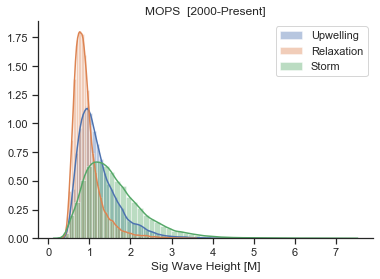

In [211]:
fig, ax1 = plt.subplots()
sns.distplot( df_mean.query('season == "upwelling"')['wvht'].dropna().values,ax=ax1,label='Upwelling')
sns.distplot( df_mean.query('season == "relaxation"')['wvht'].dropna().values,ax=ax1, label='Relaxation')
sns.distplot( df_mean.query('season == "storm"')['wvht'].dropna().values,ax=ax1, label='Storm')

ax1.set_xlabel("Sig Wave Height [M]")
ax1.set_title("MOPS  [2000-Present]")
ax1.legend()
sns.despine()
# plt.savefig('../Figures/MOPS_Hs_seasonal_hist.png', dpi=200,bbox_inches='tight',pad_inches=.25)

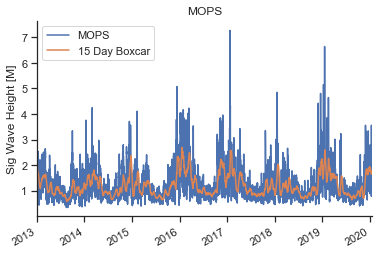

In [213]:
fig, (ax1) = plt.subplots(1)
df_mean['wvht'].plot(ax=ax1, label='MOPS')
df_mean['wvht'].rolling('15D').mean().plot(ax=ax1, label='15 Day Boxcar')
ax1.legend()
# ax1.set_ylim(0,3.25)
ax1.set_ylabel("Sig Wave Height [M]")
ax1.set_xlabel("")
ax1.set_title('MOPS')
ax1.set_xlim('20130101','20200114')
sns.despine()
plt.savefig('../Figures/MOPS_Hs_2013Present.png', dpi=200,bbox_inches='tight',pad_inches=.25)

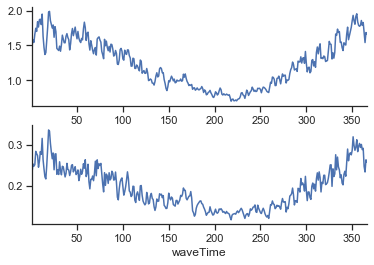

In [29]:
fig, (ax1, ax2) = plt.subplots(2)
df.groupby(df.index.dayofyear).mean().mean(axis=1).plot(ax=ax1)
df.groupby(df.index.dayofyear).mean().std(axis=1).plot(ax=ax2)
sns.despine()

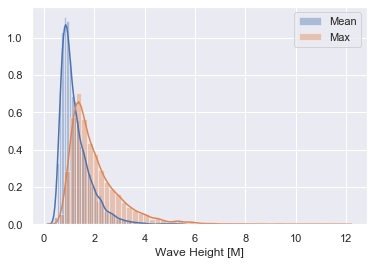

In [21]:
fig, ax1 = plt.subplots()
daily_mean = df.resample('1D').mean()
sns.distplot(daily_mean.mean(axis=1).values, norm_hist=True,label='Mean');
daily_max = df.resample('1D').max()
sns.distplot(daily_max.max(axis=1), norm_hist=True,label='Max');
# ax1.set_xlim(0, 4)
ax1.set_xlabel('Wave Height [M]')
ax1.legend()

In [188]:
url = "https://coastwatch.pfeg.noaa.gov/erddap/tabledap/cwwcNDBCMet.csv?station%2Clongitude%2Clatitude%2Ctime%2Cwd%2Cwspd%2Cgst%2Cwvht%2Cdpd%2Capd%2Cmwd%2Cbar%2Catmp%2Cwtmp%2Cdewp%2Cvis%2Cptdy%2Ctide%2Cwspu%2Cwspv&station=%2246012%22&time%3E=1970-02-26T20%3A00%3A00Z&time%3C=2020-01-14T00%3A00%3A00Z"
df_ndbc = pd.read_csv(url,skiprows=[1])
df_ndbc['waveTime'] = pd.to_datetime(df_ndbc['time'])
df_ndbc.index = df_ndbc['waveTime']
df_ndbc = df_ndbc[df_ndbc.index > "20000101"]

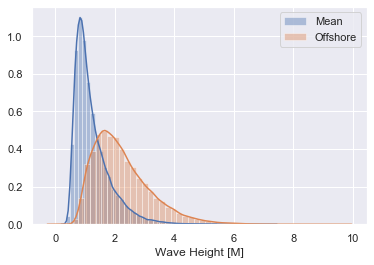

In [205]:
fig, ax1 = plt.subplots()
sns.distplot(df.mean(axis=1).values, norm_hist=True,label='Mean');
# daily_max = df.resample('1D').max()
# sns.distplot(daily_max.max(axis=1), norm_hist=False,label='Max');
# ax1.set_xlim(0, 4)
sns.distplot(df_ndbc['wvht'].dropna(), norm_hist=True,label='Offshore', ax=ax1);
ax1.set_xlabel('Wave Height [M]')
ax1.legend()

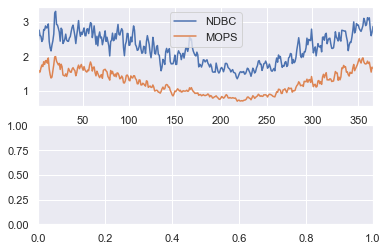

In [209]:
fig, (ax1, ax2) = plt.subplots(2)
df_ndbc.groupby(df_ndbc.index.dayofyear).mean()['wvht'].plot(ax=ax1, label='NDBC')
df.groupby(df.index.dayofyear).mean().mean(axis=1).plot(ax=ax1, label='MOPS')
ax1.legend()
df.groupby(df.index.dayofyear).mean().std(axis=1).plot(ax=ax2)
sns.despine()

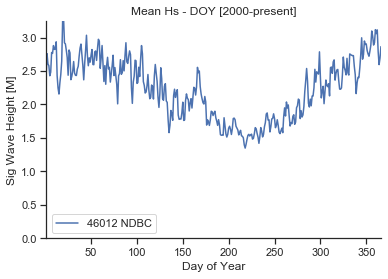

In [38]:
fig, (ax1) = plt.subplots(1)
df_ndbc.groupby(df_ndbc.index.dayofyear).mean()['wvht'].plot(ax=ax1, label='46012 NDBC')
ax1.legend()
ax1.set_ylim(0,3.25)
ax1.set_ylabel("Sig Wave Height [M]")
ax1.set_xlabel("Day of Year")
ax1.set_title('Mean Hs - DOY [2000-present]')
sns.despine()
# plt.savefig('../Figures/NDBC46012_DOY_MEAN_Hs.png', dpi=200,bbox_inches='tight',pad_inches=.25)

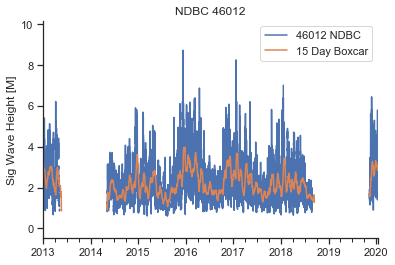

In [57]:
fig, (ax1) = plt.subplots(1)
df_ndbc['wvht'].plot(ax=ax1, label='46012 NDBC')
df_ndbc['wvht'].rolling('15D').mean().plot(ax=ax1, label='15 Day Boxcar')
ax1.legend()
# ax1.set_ylim(0,3.25)
ax1.set_ylabel("Sig Wave Height [M]")
ax1.set_xlabel("")
ax1.set_title('NDBC 46012')
ax1.set_xlim('20130101','20200114')
sns.despine()
plt.savefig('../Figures/NDBC46012_Hs_2013Present.png', dpi=200,bbox_inches='tight',pad_inches=.25)

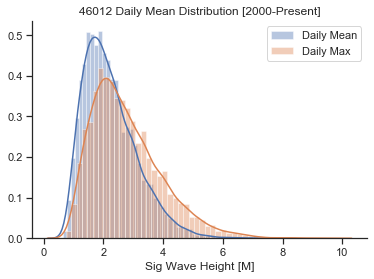

In [68]:
daily_ndbc = df_ndbc['wvht'].resample('1D').mean().dropna()
daily_max = df_ndbc['wvht'].resample('1D').max().dropna()

fig, ax1 = plt.subplots()
sns.distplot(daily_ndbc, norm_hist=True,label='Daily Mean');
sns.distplot(daily_max, norm_hist=True,label='Daily Max');
ax1.set_xlabel("Sig Wave Height [M]")
ax1.set_title("46012 Daily Mean Distribution [2000-Present]")
ax1.legend()
sns.despine()
# plt.savefig('../Figures/NDBC46012_Hs_daily_hist.png', dpi=200,bbox_inches='tight',pad_inches=.25)

In [ ]:
daily_ndbc = df_ndbc['wvht'].resample('1D').mean().dropna()
daily_max = df_ndbc['wvht'].resample('1D').max().dropna()
fig, ax1 = plt.subplots()

sns.distplot(daily_ndbc, norm_hist=True,label='Daily Mean');
sns.distplot(daily_max, norm_hist=True,label='Daily Max');
ax1.set_xlabel("Sig Wave Height [M]")
ax1.set_title("46012 Daily Mean Distribution [2000-Present]")
ax1.legend()
sns.despine()
# plt.savefig('../Figures/NDBC46012_Hs_daily_hist.png', dpi=200,bbox_inches='tight',pad_inches=.25)

In [100]:
def is_upwelling(month):
    return (month >= 3) & (month <= 6)

def is_relaxation(month):
    return (month >= 7) & (month <= 10)

def is_storm(month):
    return (month >= 11) | (month <=2)
df_ndbc['month']  = df_ndbc.index.month
df_ndbc['season'] = "nan"



df_ndbc[((df_ndbc['month']>=3) & (df_ndbc['month']<=6))]['season'] = 'upwelling'
df_ndbc[((df_ndbc['month']>=7) & (df_ndbc['month']<=10))]['season'] = 'relaxation'
df_ndbc[((df_ndbc['month']>=11) | (df_ndbc['month']<=2))]['season'] = 'storm'

In [205]:
months = df_ndbc['month'].values
seasons = df_ndbc['season'].values
ix = np.where(((months>=3)&(months<=6)))
seasons[ix] = 'upwelling'
ix = np.where(((months>=7)&(months<=10)))
seasons[ix] = 'relaxation'
ix = np.where(((months>=11)|(months<=2)))
seasons[ix] = 'storm'
df_ndbc['season'] = seasons

In [206]:
df_ndbc['season'].unique()

array(['storm', 'upwelling', 'relaxation'], dtype=object)

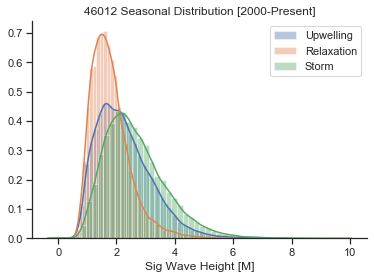

In [207]:
fig, ax1 = plt.subplots()
sns.distplot( df_ndbc.query('season == "upwelling"')['wvht'].dropna().values,ax=ax1,label='Upwelling')
sns.distplot( df_ndbc.query('season == "relaxation"')['wvht'].dropna().values,ax=ax1, label='Relaxation')
sns.distplot( df_ndbc.query('season == "storm"')['wvht'].dropna().values,ax=ax1, label='Storm')

ax1.set_xlabel("Sig Wave Height [M]")
ax1.set_title("46012 Seasonal Distribution [2000-Present]")
ax1.legend()
sns.despine()
# plt.savefig('../Figures/NDBC46012_Hs_seasonal_hist.png', dpi=200,bbox_inches='tight',pad_inches=.25)

array([3.37, 2.83, 3.47, ..., 1.55, 1.54, 1.27])

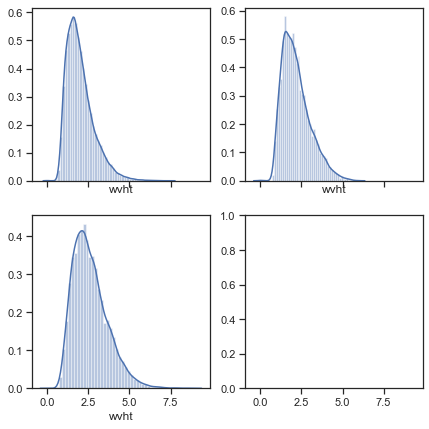

In [122]:
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
sns.distplot( df_ndbc.query('season == "upwelling"')['wvht'].dropna(),ax=axes[0,0])
sns.distplot( df_ndbc.query('season == "relaxation"')['wvht'].dropna(),ax=axes[0,1])
sns.distplot( df_ndbc.query('season == "storm"')['wvht'].dropna(),ax=axes[1,0])

In [ ]:
# Upwelling
im = (ds.sel(time=is_upwelling(ds['time.month']))['heat_content_100_meters'].mean(dim=['time'])/1E9).plot.pcolormesh(
        ax=axes[0], cmap='Spectral_r',
        vmin=3,vmax=5,
        add_colorbar=False)

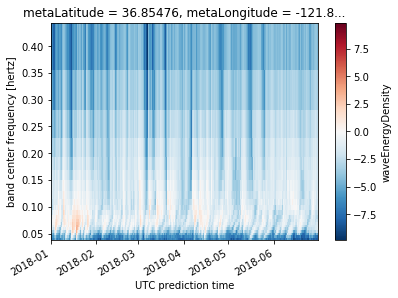

In [20]:
fig, ax =plt.subplots()
(np.log(ds['waveEnergyDensity'])).plot(x='waveTime')